In [ ]:
#---
#output-file: sample_size_effect_evaluation
#---

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide
from nbdev import show_doc, nbdev_export

# Sample size effect on evaluation metrics

> What is the optimal sample size to compare experiments?

The code and the data used in this end-to-end tutorial are available and can be reproduced in a Jupyter Notebook.

## Queries to document corpus ratio

In [ ]:
ratio_devquery_corpus = 55578/8841823
ratio_devquery_corpus

0.006285807802305023

In [ ]:
from learntorank.passage import create_basic_search_package
from learntorank.evaluation import (
    MatchRatio,
    Recall, 
    ReciprocalRank, 
    NormalizedDiscountedCumulativeGain
)
from learntorank.query import QueryModel, OR, WeakAnd, WeakAndOld, Ranking

corpus_size = [10000, 100000]#, 1000000]
app_package = create_basic_search_package()
query_models = [
    QueryModel(
        name="bm25", 
        match_phase=OR(), 
        ranking=Ranking(name="bm25")
    ),
    #QueryModel(
    #    name="native_rank", 
    #    match_phase=OR(), 
    #    ranking=Ranking(name="native_rank")
    #),
    QueryModel(
        name="weakand_10_bm25", 
        match_phase=WeakAnd(hits=10), 
        ranking=Ranking(name="bm25")
    ),
    QueryModel(
        name="weakand_old_10_bm25", 
        match_phase=WeakAndOld(hits=10), 
        ranking=Ranking(name="bm25")
    ),    
    QueryModel(
        name="weakand_100_bm25", 
        match_phase=WeakAnd(hits=100), 
        ranking=Ranking(name="bm25")
    ),
    QueryModel(
        name="weakand_old_100_bm25", 
        match_phase=WeakAndOld(hits=100), 
        ranking=Ranking(name="bm25")
    ),    
    #QueryModel(
    #    name="weakand_1000_bm25", 
    #    match_phase=WeakAnd(hits=1000), 
    #    ranking=Ranking(name="bm25")
    #)    
]
metrics = [
    MatchRatio(),
    Recall(at=100), 
    ReciprocalRank(at=10), 
    NormalizedDiscountedCumulativeGain(at=10)
]
output_file_path = "../data_learntorank/passage_weakandold_test.csv"

In [ ]:
from learntorank.passage import evaluate_query_models

estimates = evaluate_query_models(
    app_package=app_package,
    query_models=query_models,
    metrics=metrics,
    corpus_size=corpus_size,
    output_file_path=output_file_path, 
)

*****
Deploy Vespa application:
*****
Waiting for configuration server, 0/300 seconds...
Waiting for configuration server, 5/300 seconds...
Waiting for application status, 0/300 seconds...
Waiting for application status, 5/300 seconds...
Waiting for application status, 10/300 seconds...
Waiting for application status, 15/300 seconds...
Waiting for application status, 20/300 seconds...
Waiting for application status, 25/300 seconds...
Waiting for application status, 30/300 seconds...
Waiting for application status, 35/300 seconds...
Finished deployment.
*****
Corpus size:10000
*****
*****
Generate sample data:
*****
Number of documents: 9997
Number of train queries: 62
Number of train relevance judgments: 62
Number of dev queries: 62
Number of dev relevance judgments: 62
*****
Feed sample data to Vespa app:
*****
Successful documents fed: 9997/9997.
Batch progress: 1/1.
*****
Evaluate query models
*****
*****
Delete all documents
*****
*****
Corpus size:100000
*****
*****
Generate sampl

In [ ]:
import pandas as pd
import numpy as np

estimates = pd.read_csv("../data_learntorank/passage_weakandold_test.csv")

In [ ]:
estimates

,metric,model,low,median,high,corpus_size,number_queries
0,match_ratio,bm25,0.490272,0.560934,0.632507,10000,62
1,match_ratio,weakand_100_bm25,0.069803,0.081134,0.097647,10000,62
2,match_ratio,weakand_10_bm25,0.012941,0.015070,0.017603,10000,62
3,match_ratio,weakand_old_100_bm25,0.070406,0.081479,0.097936,10000,62
4,match_ratio,weakand_old_10_bm25,0.012855,0.015009,0.017402,10000,62
5,ndcg_10,bm25,0.781280,0.853397,0.915641,10000,62
6,ndcg_10,weakand_100_bm25,0.777054,0.853875,0.917841,10000,62
7,ndcg_10,weakand_10_bm25,0.728731,0.815472,0.893277,10000,62
8,ndcg_10,weakand_old_100_bm25,0.770900,0.850410,0.911520,10000,62
9,ndcg_10,weakand_old_10_bm25,0.714774,0.808821,0.883068,10000,62


In [ ]:
#estimates[["corpus_size", "number_queries"]] = estimates[["corpus_size", "number_queries"]].apply(pd.to_numeric)

In [ ]:
#print(estimates[estimates.corpus_size.apply(lambda x: isinstance(x, str))])

In [ ]:
#print(estimates[pd.to_numeric(estimates.corpus_size, errors='coerce').isnull()])

In [ ]:
#estimates.iloc[0]

In [ ]:
#estimates.dtypes

In [ ]:
#bm25_vs_native_rank = estimates.loc[estimates.model.isin(["bm25", "native_rank"])]

In [ ]:
#bm25_vs_native_rank.describe()

In [ ]:
from plotnine import *

def plot_metrics(estimates):
    return (ggplot(estimates, aes(colour = "model")) + 
            scale_x_log10(breaks=list(estimates.corpus_size.unique()), labels=list(estimates.corpus_size.unique())) + 
            theme(
                panel_grid_minor=element_blank(),
                subplots_adjust={'wspace': 0.15},
                legend_position = 'top'
            ) +
            geom_point(aes(x = "corpus_size", y = "median")) + 
            geom_line(aes(x = "corpus_size", y = "median")) + 
            geom_errorbar(aes(x="corpus_size", ymin="low",ymax="high")) + 
            facet_wrap("metric", scales="free_y") + labs(y="Metric value")
           )

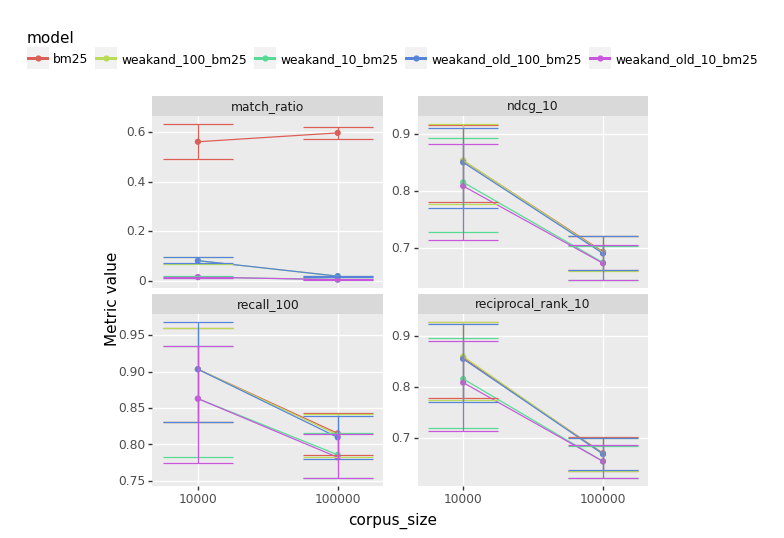

In [ ]:
print(plot_metrics(estimates))

In [ ]:
print(plot_metrics(bm25_vs_native_rank))

NameError: name 'bm25_vs_native_rank' is not defined

In [ ]:
weak_and_estimates = estimates.loc[~estimates.model.isin(["native_rank"])]

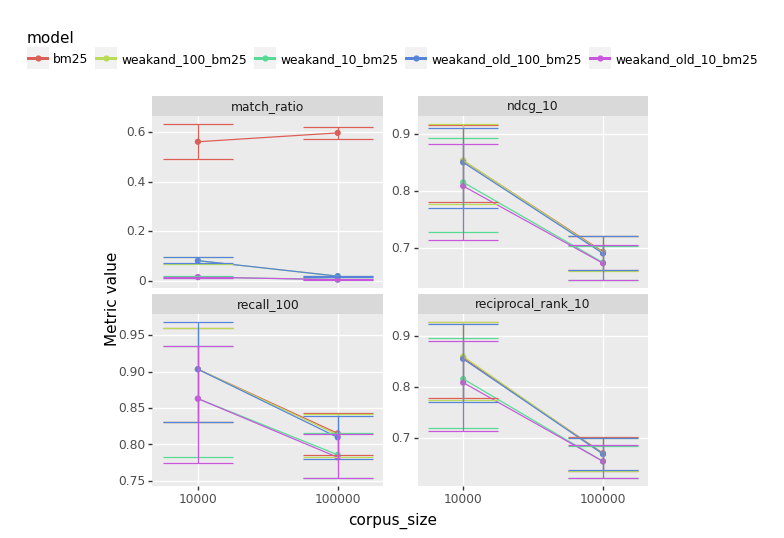

In [ ]:
print(plot_metrics(weak_and_estimates))

In [ ]:
weak_and_estimates

In [ ]:
weakand_1000000_estimates = weak_and_estimates.loc[weak_and_estimates.corpus_size == 1000000]

In [ ]:
(ggplot(weakand_1000000_estimates) + 
 #scale_x_log10(breaks=list(estimates.corpus_size.unique()), labels=list(estimates.corpus_size.unique())) + 
 theme(
     panel_grid_minor=element_blank(),
     axis_text_x=element_text(rotation=90, hjust=1),
    subplots_adjust={'wspace': 0.25},
    legend_position = 'top'
) +
geom_point(aes(x = "model", y = "median")) + 
geom_line(aes(x = "model", y = "median")) + 
geom_errorbar(aes(x="model", ymin="low",ymax="high")) + 
facet_wrap("metric", scales="free_y") + labs(y="Metric value")
)

## TODO

* Eu vou usar OR como match phase e dps faco uma analise com hits do weakAND

* Incluir o timing como comparar OR e weakAnd

## Cleanup the environment

In [ ]:
vespa_docker.container.stop(timeout=600)
vespa_docker.container.remove()

NameError: name 'vespa_docker' is not defined

In [ ]:
#|hide
nbdev_export()